# Letterboxd Movie Recommender — Notebook

This notebook is a **complete, runnable starter** for the Letterboxd recommender project. It follows the architecture: Data load → Cleaning → TF-IDF (content) → LDA → Sentiment → Collaborative (SVD/item-item) → Hybrid recommendation. 

Place your CSV files in `letterboxd-movie-ratings-data/` with filenames:
- `movie_data.csv`
- `ratings_export.csv`
- `users_export.csv`

Run the cells in order. The notebook contains fallbacks so it runs even if some optional packages are missing.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import save_npz
import matplotlib.pyplot as plt

# Gensim for LDA
from gensim import corpora
from gensim.models import LdaModel

# NLP & ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob

from scipy.sparse import hstack, csr_matrix

# optional surprise
import surprise
from surprise import Dataset, Reader, SVD

try:
    HAVE_SURPRISE = True
except Exception:
    HAVE_SURPRISE = False

print('HAVE_SURPRISE =', HAVE_SURPRISE," | Surprise version:", surprise.__version__)

HAVE_SURPRISE = True  | Surprise version: 1.1.4


In [2]:
movies = pd.read_csv("clean_movies.csv")

In [3]:
print("nmovies.columns:",
      movies.columns)

nmovies.columns: Index(['movie_id', 'movie_name', 'genres', 'description', 'year', 'popularity',
       'vote_average', 'vote_count'],
      dtype='object')


In [4]:
movies.head(2)

,movie_id,movie_name,genres,description,year,popularity,vote_average,vote_count
0,football-freaks,Football Freaks,Music Animation,football freak football freak football crazy f...,1971.0,0.6,0.0,0.0
1,aftermath-1960,Aftermath,NaN,aftermath 1960 aftermath aftermath pilot unsol...,1960.0,0.6,8.0,1.0


## 6) TF-IDF vectorization + cosine similarity (content-based)

In [5]:
tfidf = TfidfVectorizer(max_features=100000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(movies['description'].fillna(''))

print('TF-IDF matrix shape:', tfidf_matrix.shape)

TF-IDF matrix shape: (285963, 100000)


In [6]:
TOP_K = 10000  # nombre de films similaires à récupérer
batch_size = 1000
n = tfidf_matrix.shape[0]
# On va stocker seulement les indices et scores top-K
topk_indices = np.zeros((n, TOP_K), dtype=np.int32)
topk_scores = np.zeros((n, TOP_K), dtype=np.float32)

In [7]:
for i in range(0, n, batch_size):
    end = min(i + batch_size, n)
    print(f"Processing batch {i} → {end}")
    
    # Calculer la similarité du batch actuel avec tous les films
    sim_batch_TOP_K = cosine_similarity(tfidf_matrix[i:end], tfidf_matrix)
    
    # Pour chaque film du batch, récupérer les TOP_K indices et scores
    for j, row in enumerate(sim_batch_TOP_K):
        top_indices = np.argsort(row)[-TOP_K-1:-1][::-1]  # ignore soi-même
        top_scores = np.sort(row)[-TOP_K-1:-1][::-1]
        topk_indices[i+j] = top_indices
        topk_scores[i+j] = top_scores

print("✅ Top-K similarity computation finished")
print("Shapes:", topk_indices.shape, topk_scores.shape)

Processing batch 268000 → 269000
Processing batch 269000 → 270000
Processing batch 270000 → 271000
Processing batch 271000 → 272000
Processing batch 272000 → 273000
Processing batch 273000 → 274000
Processing batch 274000 → 275000
Processing batch 275000 → 276000
Processing batch 276000 → 277000
Processing batch 277000 → 278000
Processing batch 278000 → 279000
Processing batch 279000 → 280000
Processing batch 280000 → 281000
Processing batch 281000 → 282000
Processing batch 282000 → 283000
Processing batch 283000 → 284000
Processing batch 284000 → 285000
Processing batch 285000 → 285963
✅ Top-K similarity computation finished
Shapes: (285963, 10000) (285963, 10000)


## 7) Topic modeling (LDA)

In [8]:
texts = [t.split() for t in movies['description'].fillna('')]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(t) for t in texts]

print("Dictionary size:", len(dictionary))
print("Corpus length:", len(corpus))

Dictionary size: 214146
Corpus length: 285963


In [9]:
if len(dictionary) > 0:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=3, random_state=42)
    topics = lda.print_topics(num_words=10)
    print("\n✅ Extracted Topics:\n")
    for t in topics:
        print(t)
else:
    print("❌ Dictionary is empty — cannot train LDA model.")


✅ Extracted Topics:

(0, '0.027*"war" + 0.020*"documentary" + 0.018*"drama" + 0.017*"story" + 0.017*"history" + 0.010*"american" + 0.008*"world" + 0.008*"country" + 0.007*"state" + 0.007*"people"')
(1, '0.016*"los" + 0.016*"island" + 0.013*"sea" + 0.012*"road" + 0.011*"water" + 0.008*"river" + 0.007*"la" + 0.007*"park" + 0.007*"moon" + 0.007*"fire"')
(2, '0.022*"life" + 0.016*"drama" + 0.014*"year" + 0.013*"one" + 0.011*"day" + 0.010*"family" + 0.009*"old" + 0.008*"time" + 0.007*"story" + 0.007*"friend"')
(3, '0.027*"action" + 0.017*"science" + 0.016*"fiction" + 0.014*"crime" + 0.010*"thriller" + 0.009*"police" + 0.007*"earth" + 0.007*"world" + 0.007*"adventure" + 0.006*"2022"')
(4, '0.007*"brother" + 0.007*"western" + 0.007*"town" + 0.007*"action" + 0.006*"red" + 0.006*"gang" + 0.005*"get" + 0.005*"white" + 0.005*"horse" + 0.004*"gold"')
(5, '0.070*"animation" + 0.025*"adventure" + 0.023*"comedy" + 0.022*"family" + 0.021*"christmas" + 0.016*"fantasy" + 0.013*"king" + 0.012*"dog" + 0.

In [10]:
lda_vectors_batches = []
batch_size = 10000
for i in range(0, len(corpus), batch_size):
    batch_corpus = corpus[i:i+batch_size]
    batch_lda = np.zeros((len(batch_corpus), 10))  # 8 topics
    for j, doc in enumerate(batch_corpus):
        for topic_id, prob in lda.get_document_topics(doc):
            batch_lda[j, topic_id] = prob
    lda_vectors_batches.append(batch_lda)

## 8) Sentiment analysis (optional)

Text(0.5, 1.0, 'Sentiment distribution (movies)')

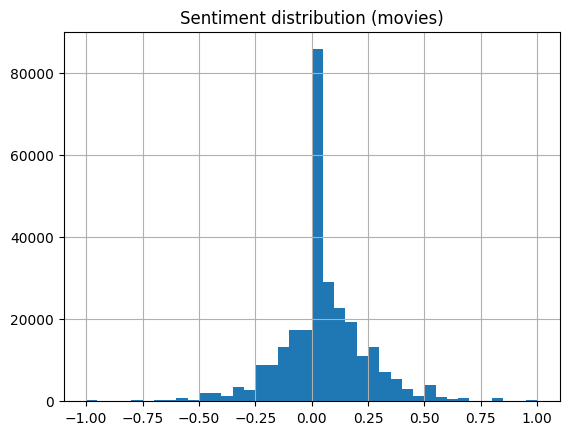

In [11]:
# We'll compute sentiment on movie clean_text as a quick proxy
movies['sentiment'] = movies['description'].fillna('').apply(lambda t: TextBlob(t).sentiment.polarity)
movies['sentiment'].hist(bins=40)
sentiment_vector = movies['sentiment'].values.reshape(-1,1)
plt.title('Sentiment distribution (movies)')

In [12]:
final_batches = []
for i, batch_lda in enumerate(lda_vectors_batches):
    # TF-IDF batch
    start = i * batch_size
    end = min((i+1)*batch_size, n)
    tfidf_batch = tfidf_matrix[start:end]
    
    # Sentiment batch
    sentiment_batch = sentiment_vector[start:end]
    
    # Fusion (TF-IDF sparse + LDA dense + sentiment dense)
    batch_final = hstack([tfidf_batch, csr_matrix(batch_lda), csr_matrix(sentiment_batch)])
    final_batches.append(batch_final)
    print(f"Fused batch {i} shape: {batch_final.shape}")

Fused batch 0 shape: (10000, 100011)
Fused batch 1 shape: (10000, 100011)
Fused batch 2 shape: (10000, 100011)
Fused batch 3 shape: (10000, 100011)
Fused batch 4 shape: (10000, 100011)
Fused batch 5 shape: (10000, 100011)
Fused batch 6 shape: (10000, 100011)
Fused batch 7 shape: (10000, 100011)
Fused batch 8 shape: (10000, 100011)
Fused batch 9 shape: (10000, 100011)
Fused batch 10 shape: (10000, 100011)
Fused batch 11 shape: (10000, 100011)
Fused batch 12 shape: (10000, 100011)
Fused batch 13 shape: (10000, 100011)
Fused batch 14 shape: (10000, 100011)
Fused batch 15 shape: (10000, 100011)
Fused batch 16 shape: (10000, 100011)
Fused batch 17 shape: (10000, 100011)
Fused batch 18 shape: (10000, 100011)
Fused batch 19 shape: (10000, 100011)
Fused batch 20 shape: (10000, 100011)
Fused batch 21 shape: (10000, 100011)
Fused batch 22 shape: (10000, 100011)
Fused batch 23 shape: (10000, 100011)
Fused batch 24 shape: (10000, 100011)
Fused batch 25 shape: (10000, 100011)
Fused batch 26 shape: 

## 9) Collaborative model training (SVD) — train once

If `surprise` is installed we train SVD. Otherwise we build an item-item similarity fallback.


In [13]:
# Prepare minimal ratings_df
ratings_small = pd.read_csv("merged_movies_ratings_users.csv")[['username','movie_id','rating']].copy()

In [14]:

if HAVE_SURPRISE:
    print('Training surprise SVD (this may take time).')
    reader = Reader(rating_scale=(ratings_small['rating'].min(), ratings_small['rating'].max()))
    data = Dataset.load_from_df(ratings_small[['username','movie_id','rating']], reader)
    trainset = data.build_full_trainset()
    algo = SVD(n_factors=50, n_epochs=20, random_state=42)
    algo.fit(trainset)
    collab_model = {'type':'surprise_svd','model':algo}
    print('SVD trained.')
else:
    print('Building item-item fallback (pivot + cosine).')
    #pivot = ratings_small.pivot_table(index='movie_id', columns='username', values='rating').fillna(0)
    #mat = pivot.values
    #norms = np.linalg.norm(mat, axis=1, keepdims=True)
    #norms[norms==0] = 1
    #mat_n = mat / norms
    #item_sim = np.dot(mat_n, mat_n.T)
    #movie_ids = list(pivot.index)
    #id_to_index = {mid:i for i,mid in enumerate(movie_ids)}
    #collab_model = {'type':'item_item','sim_matrix':item_sim,'movie_ids':movie_ids,'id_to_index':id_to_index}
    #print('Item-item model ready.')

Training surprise SVD (this may take time).
SVD trained.


## 11) Save models (optional)
You can save TF-IDF, cosine similarity, and collaborative model to disk for quick loading in app.

In [15]:
os.makedirs('topk_data', exist_ok=True)

# Assuming topk_indices and topk_scores are NumPy arrays
np.save('topk_data/topk_indices.npy', topk_indices)
np.save('topk_data/topk_scores.npy', topk_scores)

topk_indices.npy,topk_scores.npy,svd_model.pkl,fused_batches

In [16]:
# Save the SVD model
with open("svd_model.pkl", "wb") as f:
    pickle.dump(collab_model, f)

print("✅ SVD model saved as svd_model.pkl")

✅ SVD model saved as svd_model.pkl


In [ ]:
output_dir = "fused_batches"
os.makedirs(output_dir, exist_ok=True)

for i, batch in enumerate(final_batches):
    save_npz(os.path.join(output_dir, f"fused_batch_{i}.npz"), batch)

print(f"✅ {len(final_batches)} fused batches saved in '{output_dir}/'")

✅ 29 fused batches saved in 'fused_batches/'


: 